# TRAWLING4PACE 
## Fish-PACE Hackweek 1/26/26-1/30/26
**Project members:** 
* Mary Kate Munley
* Justine Whitaker
* Victoria Abunaw
* Punya Puthukulangara
* Frederic Bonou
* Leandro Machado Cruz
* Haley Synan <br>

**Research question:** Can PACE data be used as predictors for catch abundance for Silver Hake in the NorthWest Atlantic? Which models are the best predictors? <br>
**Datasets**:
* NOAA NEFSC Bottom Trawl Survey Data (Spring 2024, Fall 2024, Spring 2025)
* PACE datasets
* GLORYS modeled datasets


In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
import numpy as np
import cartopy

In [5]:
os.chdir('/home/jovyan/2026-proj-Trawling4PACE/data')

# Read data 

The data we are using for this project is the NOAA NEFSC Bottom Trawl Survey Data. We are only using the surveys that coincide with the PACE timeline, Spring 2024, Fall 2024, and Spring 2025. 

In [3]:
df= pd.read_csv('/home/jovyan/2026-proj-Trawling4PACE/contributor_folders/leandro/correlation_data.csv')

### Data cleaning
Here we need to split the datetime string into day, month, year, and day of year (doy). Note because we are training a random forest we don't need to scale the data. 

In [3]:
#Data cleaning 
#all values in glorys_thetao_bottom are NAN so we need to clean them out 
df['month']=pd.to_datetime(df.BEGIN_GMT_TOWDATE).dt.month
df['day']=pd.to_datetime(df.BEGIN_GMT_TOWDATE).dt.day
df['year']=pd.to_datetime(df.BEGIN_GMT_TOWDATE).dt.year
df['doy']= [datetime.date(df.year[x],df.month[x],df.day[x]).timetuple().tm_yday for x in df.index]

df = df.drop(['glorys_thetao_bottom','BEGIN_GMT_TOWDATE'],axis=1).dropna()

# standardizing variables / outlier removal 
#scaler = MinMaxScaler()
#df_scaled= scaler.fit_transform(df)
#df=pd.DataFrame(df_scaled, columns=df.columns)

### Split data 
We are predicting species abundance (catch number) and using other variables from the in-situ data and PACE as predictors. We then split the data into 80% as training data and 20% as testing data.

In [4]:
#SPLIT DATA INTO TRAINING/TESTING 
y = df['EXPCATCHNUM_log']
X = df[['DECDEG_ENDLAT', 'DECDEG_ENDLON', 'curl_stress_curl', 'fsle_fsle_max','glorys_mlotst_surface',
       'glorys_thetao_surface','BOTTEMP', 'BOTSALIN', 'SURFSALIN', 'SURFTEMP','doy']]

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training! 
Here we are comparing the output from two different models: a random forest and boosted regression tree. 
## Random forest
#### Hyperparameterization

In [5]:
#hyperparameterization
param_grid={'n_estimators':[100,200,300],
            'max_features':['sqrt','log2',0.8],
           'max_depth':[10,20,30,None]}
from sklearn.model_selection import GridSearchCV
model=RandomForestRegressor()
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train_scaled)

# Print the best hyperparameters found
print(grid_search.best_params_)

# Print the best score achieved (neg_mean_squared_error, so lower is better for actual MSE)
print(grid_search.best_score_)

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
-0.7823538719927297


### Train the Random forest model 

In [6]:
#n_estimators == # of decision trees 
#oob_score == out of bag estimate of models general error
#random_state is for reproducibility

#optimize the number of trees?
#hyperparameterization
regressor = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'], max_features= grid_search.best_params_['max_features'],max_depth = grid_search.best_params_['max_depth'],random_state=0, oob_score=True)

regressor.fit(X_train_scaled, y_train_scaled)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

### Predict abundances 

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions = regressor.predict(X_test_scaled)

mse = mean_squared_error(y_test_scaled, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test_scaled, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: -0.04474544268344771
Mean Squared Error: 0.7384203209597963
R-squared: -0.01295471512927504


### Check feature importance 

In [8]:
importances = regressor.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Gini Importance': importances}).sort_values(
    'Gini Importance', ascending=False)
print(feature_imp_df)

                  Feature  Gini Importance
7                BOTSALIN         0.130739
6                 BOTTEMP         0.129664
1           DECDEG_ENDLON         0.102294
0           DECDEG_ENDLAT         0.100992
3           fsle_fsle_max         0.100868
8               SURFSALIN         0.097826
5   glorys_thetao_surface         0.078779
9                SURFTEMP         0.074267
10                    doy         0.072104
4   glorys_mlotst_surface         0.059391
2        curl_stress_curl         0.053076


## Boosted regression tree

In [9]:
#BOOSTED REGRESSION TREE 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
#import shap

#### Hyperparameterization

In [195]:
param_grid={'n_estimators':[100,200,300],
            'learning_rate':[0.1,0.05,0.01],
           'max_depth':[5,10,20,30,None],
           'reg_alpha':[0.005, .05, .1],
           'reg_lambda':[0.05, 0.1, 1, 2]}
from sklearn.model_selection import GridSearchCV
model=xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train_scaled)

# Print the best hyperparameters found
print(grid_search.best_params_)

# Print the best score achieved (neg_mean_squared_error, so lower is better for actual MSE)
print(grid_search.best_score_)


KeyboardInterrupt



### Train model

In [10]:
xgb_reg = xgb.XGBRegressor(
    # --- Boosting Parameters (How the model learns) ---
    n_estimators=100,         # Analogous to the "richness" of the model. Number of trees to build.
                               # We set this high and use early stopping to find the optimal number.
    learning_rate=0.01,        # Analogous to a shrinkage parameter. Lower values make the model more robust.

    # --- Tree Complexity Parameters ---
    max_depth=5,               # Analogous to `k` in s(x, k=...). Controls max interaction depth.
    min_child_weight=1,        # A form of regularization. Prevents learning highly specific patterns.
    gamma=0.1,                 # Analogous to `sp`. A value > 0 penalizes splits, making the model more conservative.
    subsample=0.8,             # Use 80% of data for building each tree. Adds randomness to fight overfitting.
    colsample_bytree=0.8,      # Use 80% of features for building each tree. Also for overfitting.

    # --- Regularization Parameters ---
    reg_alpha=0.1,           # L1 regularization on leaf weights.
    reg_lambda=2,              # L2 regularization on leaf weights.

    # --- Technical Parameters ---
    objective='reg:squarederror', # The loss function to optimize.
    n_jobs=-1,                 # Use all available CPU cores.
    random_state=42,           # For reproducibility.
    eval_metric='rmse'         # Metric to monitor during training.
)

print("Model initialized with parameters:")
print(xgb_reg.get_params())

xgb_reg.fit(X_train_scaled, y_train_scaled,
            eval_set=[(X_test_scaled, y_test_scaled)],
            verbose=False) # Set verbose=True to see the training progress

print(f"Model training complete.")

Model initialized with parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'rmse', 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 2, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Model training complete.


In [11]:
results = xgb_reg.evals_result()
best_iteration = np.argmin(results['validation_0']['rmse'])
best_score = results['validation_0']['rmse'][best_iteration]

print(f"Best iteration found: {best_iteration}")
print(f"Best validation RMSE: {best_score:.4f}")

Best iteration found: 97
Best validation RMSE: 0.8473


### Predict abundances

In [12]:
predictions_brt = xgb_reg.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions_brt))
print(f"Final RMSE on validation data: {rmse:.4f}")

Final RMSE on validation data: 0.8474


### Check feature importance 

Plotting feature importance...


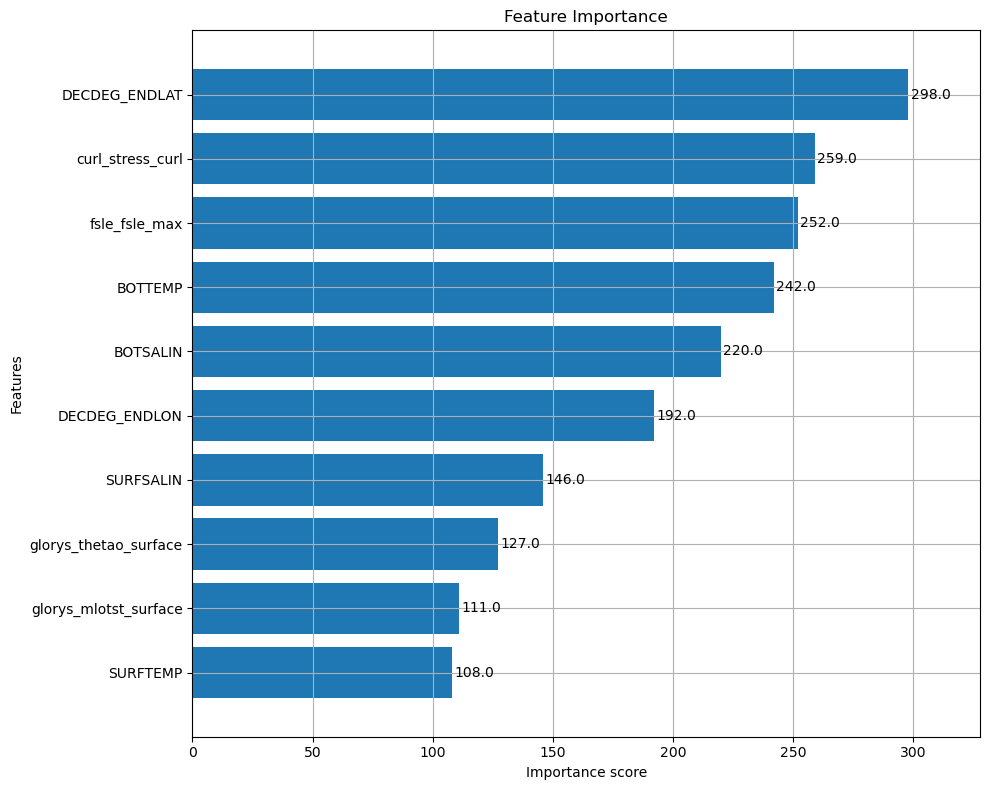

In [13]:
print("Plotting feature importance...")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_reg, ax=ax, max_num_features=10, height=0.8, title="Feature Importance")
plt.tight_layout()
plt.show()

In [14]:
mse = mean_squared_error(y_test_scaled, predictions_brt)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test_scaled, predictions_brt)
print(f'R-squared: {r2}')

Mean Squared Error: 0.7180358530999011
R-squared: 0.015008414064194286


Having such low R-squared values for both models means that the predictors didn't really explain any of the variation in the catch data

## Interpret results
### Partial dependence plots 
How to interpret: <br>
Partial dependence plots isolate the effect of one variable on the model's output. The single variable is on the x-axis, and the model's predicted catch at each value of that variable averaged over all other predictors in the dataset is on the y-axis. <br>
* If the PPD line is flat: the variable has no meaningful effect on the catch
* If the PPD line increases/decreases consistently: there is a consistent relationship between the variable and predicted catch (ie increased temperature = increased catch)
* Hump-shaped curve: there is an optimal range at for catch
* Noisy line: the predictor is weak, there isn't enough data, or the model is overfitting 


/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:721: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


Text(0.5, 0.95, 'Partial Dependence plots for RF')

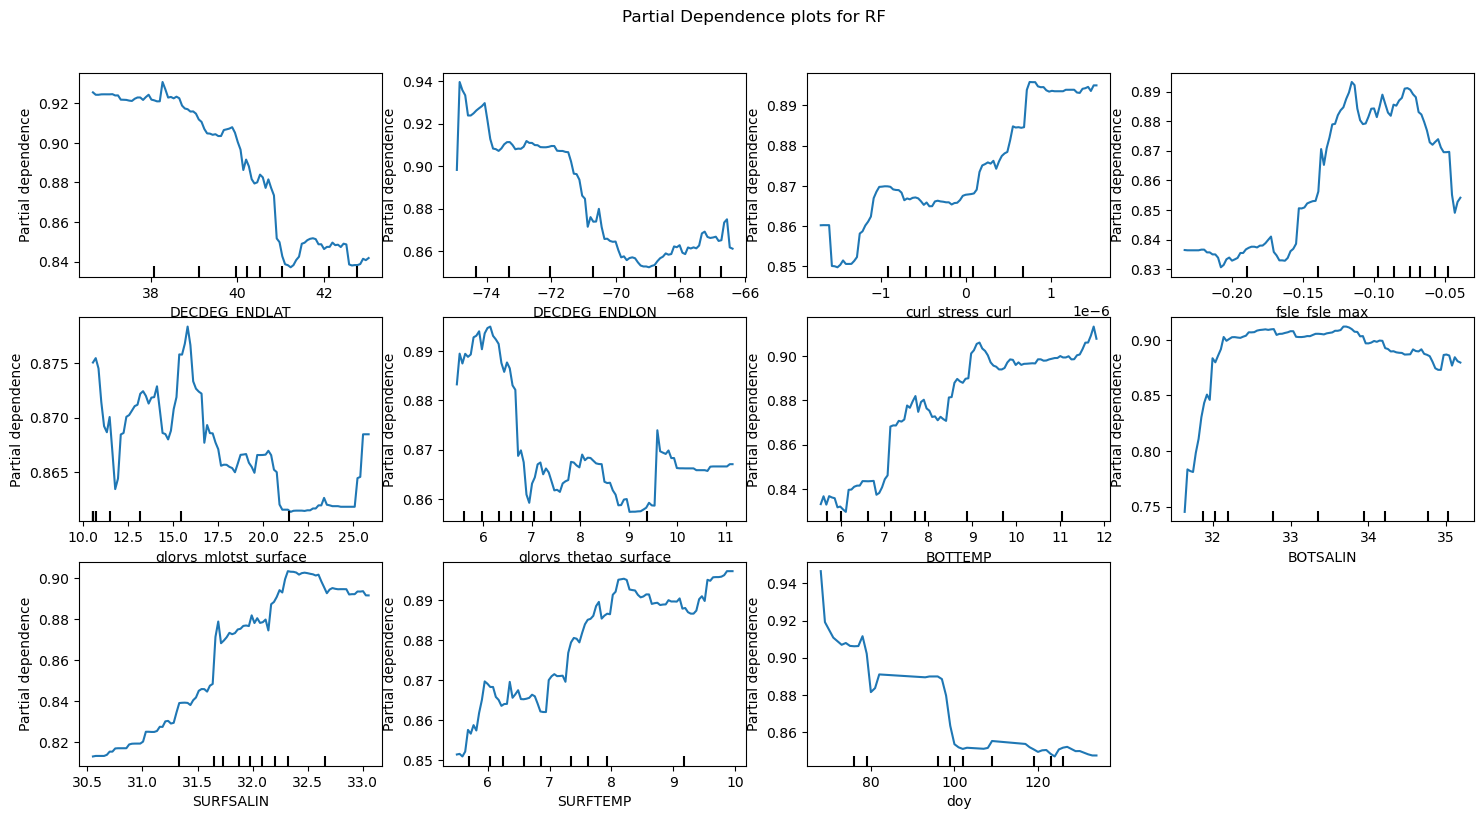

In [15]:
#RANDOM FOREST 
from sklearn.inspection import PartialDependenceDisplay
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 9))
# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten()

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    try: 
        PartialDependenceDisplay.from_estimator(
                            estimator=regressor,
                            X=X_train_scaled,
                            features=[X_train_scaled.columns[i]],
                            target='EXPCATCHNUM',  
                            ax=ax
                        )
        #ax.set_title(f"{species}")
        ax.set_ylabel("Partial Dependence (log CPUE scale)")
    except IndexError:
        ax.remove()

fig.suptitle('Partial Dependence plots for RF',y=0.95)

/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:721: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


Text(0.5, 0.95, 'Partial Dependence plots for BRT')

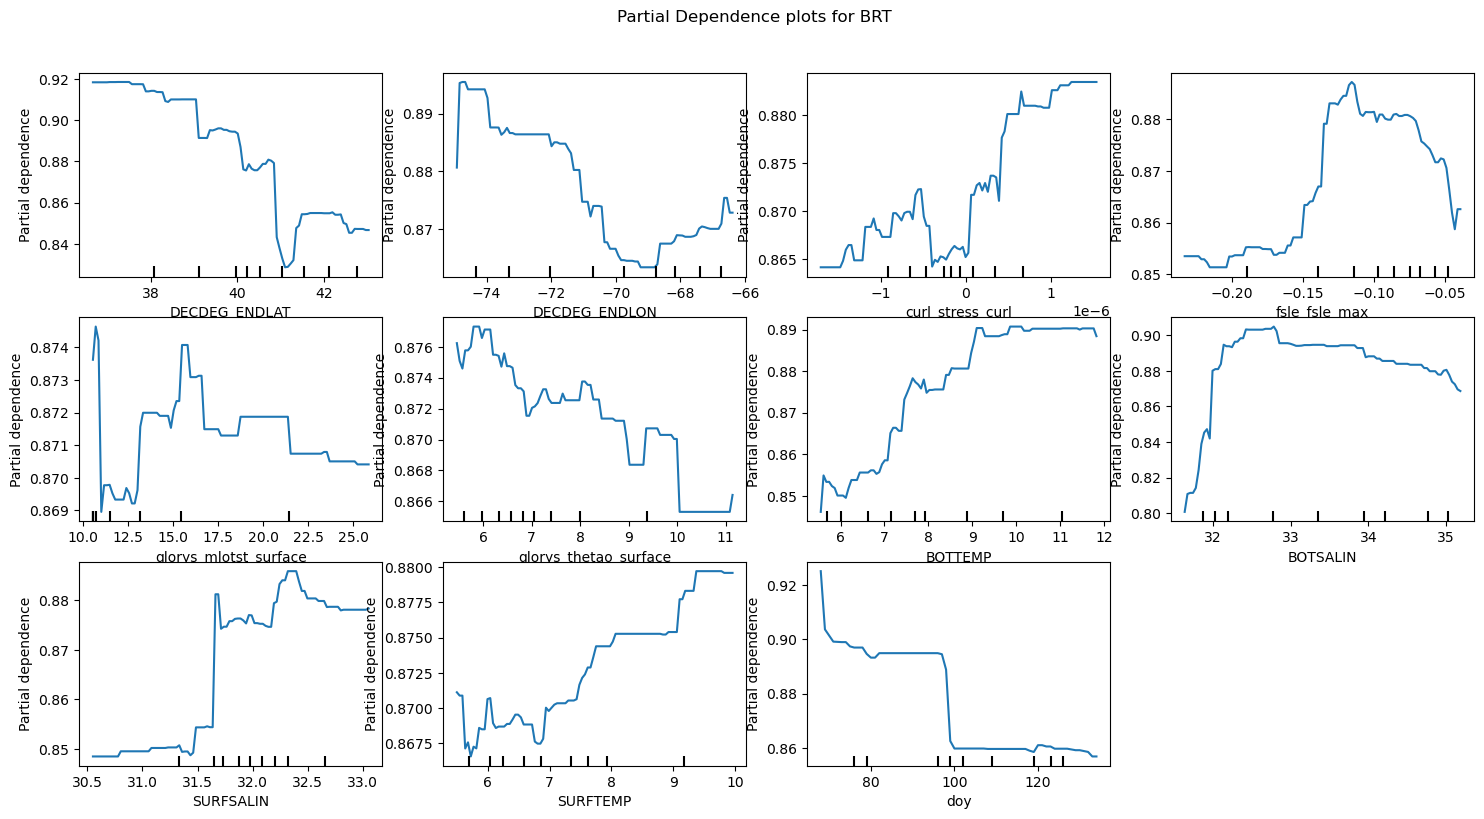

In [16]:
#BOOSTED REGRESSION TREE
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 9))
# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten()

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    try: 
        PartialDependenceDisplay.from_estimator(
                            estimator=xgb_reg,
                            X=X_train_scaled,
                            features=[X_train_scaled.columns[i]],
                            target='EXPCATCHNUM',  
                            ax=ax
                        )
        #ax.set_title(f"{species}")
        ax.set_ylabel("Partial Dependence (log CPUE scale)")
    except IndexError:
        ax.remove()

fig.suptitle('Partial Dependence plots for BRT',y=.95)

## Visualize results

Text(0.5, 0.7, 'Silver Hake Abundance')

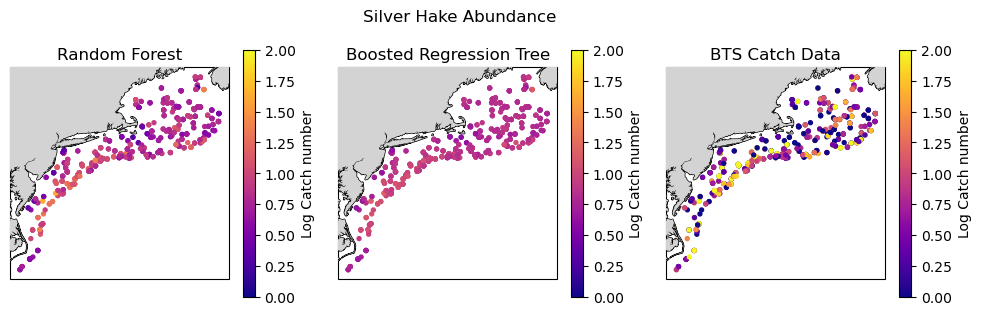

In [25]:
#VISUALIZE RESULTS

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection': cartopy.crs.PlateCarree()}, figsize=(12, 8))
im=ax1.scatter(df.loc[X_test_scaled.index.tolist()].DECDEG_ENDLON, df.loc[X_test_scaled.index.tolist()].DECDEG_ENDLAT, c=predictions,vmin=0,vmax=2,cmap='plasma',s=8)
ax1.set_title('Random Forest')
fig.colorbar(im, ax=ax1,shrink=0.4,label='Log Catch number')
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=1)
ax1.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')

im1=ax2.scatter(df.loc[X_test_scaled.index.tolist()].DECDEG_ENDLON, df.loc[X_test_scaled.index.tolist()].DECDEG_ENDLAT, c=predictions_brt,vmin=0,vmax=2,cmap='plasma',s=8)
ax2.set_title('Boosted Regression Tree')
fig.colorbar(im1, ax=ax2,shrink=0.4,label='Log Catch number')
ax2.add_feature(cartopy.feature.COASTLINE, linewidth=1)
ax2.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')

im2=ax3.scatter(df.loc[X_test_scaled.index.tolist()].DECDEG_ENDLON, df.loc[X_test_scaled.index.tolist()].DECDEG_ENDLAT, c=df.loc[y_test_scaled.index.tolist()].EXPCATCHNUM_log,cmap='plasma',vmin=0,vmax=2,s=8)
ax3.set_title('BTS Catch Data')
fig.colorbar(im2, ax=ax3,shrink=0.4,label='Log Catch number')
ax3.add_feature(cartopy.feature.COASTLINE, linewidth=1)
ax3.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')
fig.suptitle('Silver Hake Abundance', y=0.7)

We can see that the predictions from both models are significantly lower than the in-situ catch numbers.


Text(1, 1.17, 'RMSE: 0.127')

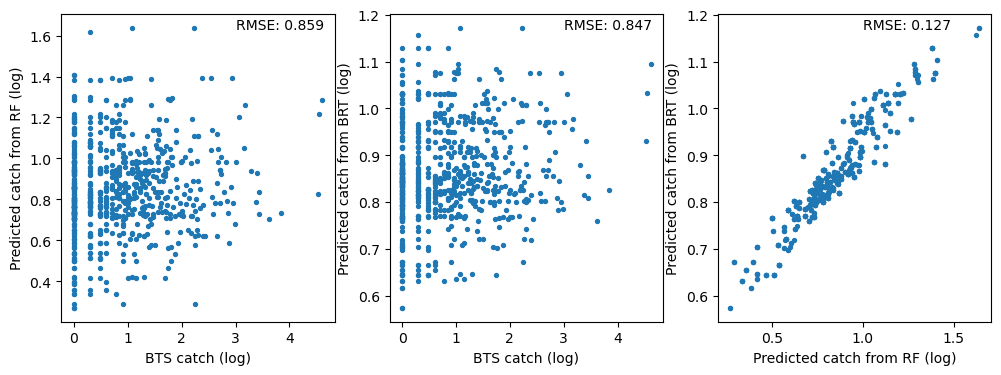

In [81]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4)) 
ax1.scatter(df.loc[y_test_scaled.index.tolist()].EXPCATCHNUM_log, predictions,s=8)
ax1.set_xlabel('BTS catch (log)')
ax1.set_ylabel('Predicted catch from RF (log)')

ax2.scatter(df.loc[y_test_scaled.index.tolist()].EXPCATCHNUM_log, predictions_brt,s=8)
ax2.set_xlabel('BTS catch (log)')
ax2.set_ylabel('Predicted catch from BRT (log)')

ax3.scatter(predictions, predictions_brt,s=8)
ax3.set_xlabel('Predicted catch from RF (log)')
ax3.set_ylabel('Predicted catch from BRT (log)')


ax1.text(3,1.63, f'RMSE: {np.round(np.sqrt(np.mean((df.loc[y_test_scaled.index.tolist()].EXPCATCHNUM_log - predictions)**2)),3)}')
ax2.text(3,1.17, f'RMSE: {np.round(np.sqrt(np.mean((df.loc[y_test_scaled.index.tolist()].EXPCATCHNUM_log - predictions_brt)**2)),3)}')
ax3.text(1,1.17, f'RMSE: {np.round(np.sqrt(np.mean((predictions - predictions_brt)**2)),3)}')


#### Bland Altman plots
The mean difference (bias) line is shown in red and the limit of agreement (LOA) lines are shown in dashed gray lines. A narrow range of LOA means predictions are close to the observations. A wide LOA range means that predictions vary a lot. If the points are scattered around zero, then the model error are stable. If there is a slope, then the error varies with catch size.

Text(0.5, 1.0, 'RF predictions v BRT predictions')

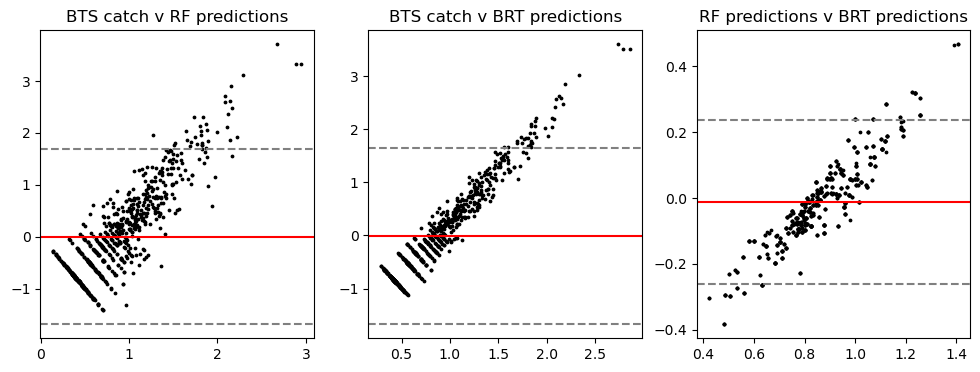

In [89]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4)) 
x=df.loc[y_test_scaled.index.tolist()].EXPCATCHNUM_log
y=predictions
differences= x-y
mean= (x+y)/2
ax1.scatter(mean, differences,s=3,c='black')
ax1.axhline(np.mean(differences), color='red', linestyle='-', label='Mean Diff')
ax1.axhline(np.mean(differences) + 1.96*np.std(differences), color='gray', linestyle='--', label='Limits of agreement')
ax1.axhline(np.mean(differences) - 1.96*np.std(differences), color='gray', linestyle='--')
ax1.set_title('BTS catch v RF predictions')
#ax1.text(0.03, 0.12, f'N={len(x)}\nMAPE={((abs(x - y) / abs(x)).mean()*100).round(3)}', horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes, fontsize=9)

x=df.loc[y_test_scaled.index.tolist()].EXPCATCHNUM_log
y=predictions_brt
differences= x-y
mean= (x+y)/2
ax2.scatter(mean, differences,s=3,c='black')
ax2.axhline(np.mean(differences), color='red', linestyle='-', label='Mean Diff')
ax2.axhline(np.mean(differences) + 1.96*np.std(differences), color='gray', linestyle='--', label='Limits of agreement')
ax2.axhline(np.mean(differences) - 1.96*np.std(differences), color='gray', linestyle='--')
ax2.set_title('BTS catch v BRT predictions')

x=predictions
y=predictions_brt
differences= x-y
mean= (x+y)/2
ax3.scatter(mean, differences,s=3,c='black')
ax3.axhline(np.mean(differences), color='red', linestyle='-', label='Mean Diff')
ax3.axhline(np.mean(differences) + 1.96*np.std(differences), color='gray', linestyle='--', label='Limits of agreement')
ax3.axhline(np.mean(differences) - 1.96*np.std(differences), color='gray', linestyle='--')
ax3.set_title('RF predictions v BRT predictions')

## Next steps: 
* Try simple a presence/absence model
* Train a neural network 
* Add more data <br>

We definitely need some more time to fully flesh out these models - these are simply a starting point! 


In [ ]:
#NEXT STEPS:
# victorias going statistically compare models 
# visualization of results between models 
    # look at abundance comparisons 
# SHAP analysis (and plots) 
# statistically compare performance of models output 
# are there other metrics to look at model performance?? 
# timeseries plot of predictions 
# fishing hotspots from abundance???? (we may not have enough data to look at this) 
# limitations 